# [E18] 다양한 OCR 모델 비교하기

### 목차
1. 검증용 데이터셋 준비
2. OCR 테스트
    * Google OCR API
    * keras-ocr
    * Tesseract
3. 테스트 결과 정리
4. 추가 테스트
5. 회고
---

### 루브릭 평가 기준
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?
    * 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?
    * 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?
    * 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.
    
---


# 도서 검색 OCR
* 의도: 이미지로 제공된 도서의 이름, 저자 등 텍스트를 인식하여 해당 도서를 검색

## 1. 검증용 데이터셋 준비

In [1]:
import os
 
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/books'
file_list = os.listdir(img_dir)
file_list

['book_5.jpg',
 'book_3.jpg',
 'book_6.jpg',
 'book_8.jpg',
 'book_1.jpg',
 'book_2.jpg',
 'book_4.jpg',
 'book_7.jpg']

## 2. OCR 테스트

### 2.1 Google OCR API

In [2]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [3]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(img_dir, file))
    print()

[book_5.jpg]
Texts:

"INTERNATIONAL STUDENT EDITION
foeth tiee
LINEAR ALGEBRA
AND ITS APPLICATIONS
Gilbert Strang
United States
Not for Sale in the
"

"INTERNATIONAL"

"STUDENT"

"EDITION"

"foeth"

"tiee"

"LINEAR"

"ALGEBRA"

"AND"

"ITS"

"APPLICATIONS"

"Gilbert"

"Strang"

"United"

"States"

"Not"

"for"

"Sale"

"in"

"the"
bounds: (389,453),(404,438),(412,447),(398,461)

[book_3.jpg]
Texts:

"death
What should
we believe
about the na-
ture of death?
How should the
knowledge of
our mortality
affect the way
we live?
SHELLY
KAGAN
openyalecourses
"

"death"

"What"

"should"

"we"

"believe"

"about"

"the"

"na-"

"ture"

"of"

"death?"

"How"

"should"

"the"

"knowledge"

"of"

"our"

"mortality"

"affect"

"the"

"way"

"we"

"live?"

"SHELLY"

"KAGAN"

"openyalecourses"
bounds: (238,1168),(599,1166),(599,1219),(238,1221)

[book_6.jpg]
Texts:

"DisNEp · PIXAR
INSIDE
OUT
THE JUNIOR NOVELIZATION
"

"DisNEp"

"·"

"PIXAR"

"INSIDE"

"OUT"

"THE"

"JUNIOR"

"NOVELIZATION"
bounds: (

### 2.2 keras-ocr

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


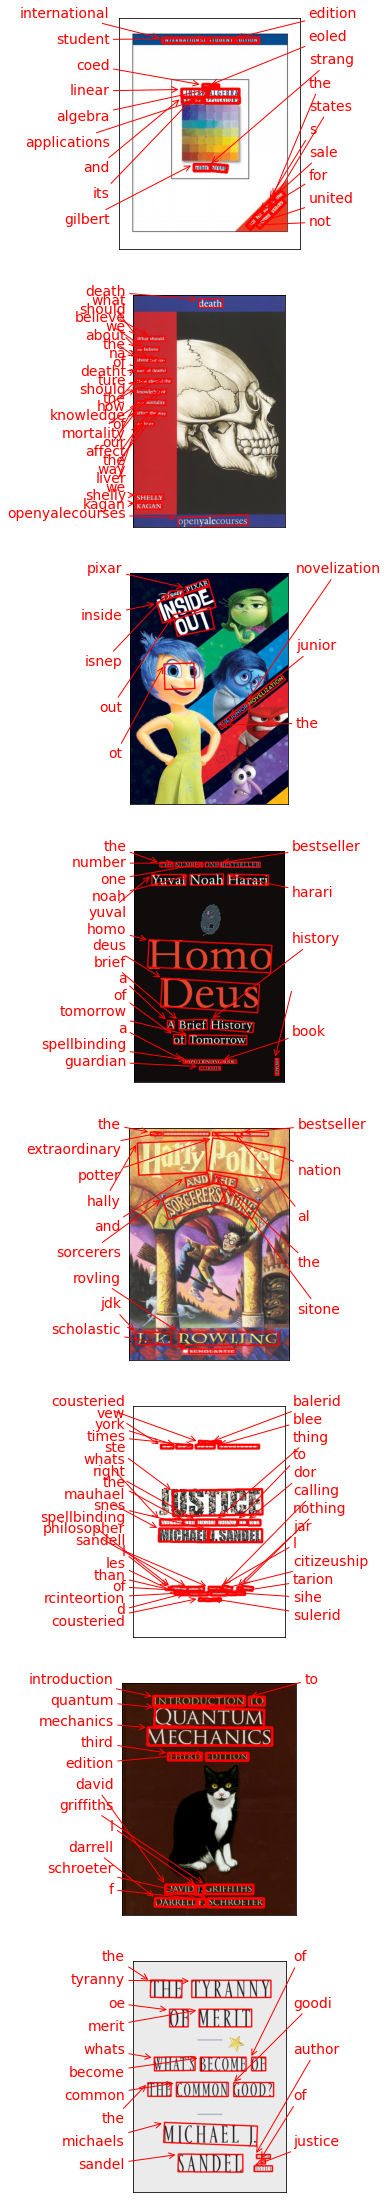

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2.3 Tesseract

In [7]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [8]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[book_5.jpg]
iNIERNAITIUOUNAL

Weietaa.

te:

JIT iOnN

yy EEEEeEeEeEeEeEeEeEeEeEEeEeEeEeEEeEEeEeEeeeeeeeeeeeeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEO ee

1INEAR

ALGEBRA

ANU)

114

APPLICATIONS

Gilbert

Strang



mm allan

c

Done
[book_3.jpg]
death

What

should

we

believe

abou

t the

tee

etice

of

deathe

wht

should

‘dele

knowledge

‘aia

OUT

mortality

af

tect the wa

y

We

Phteke

xe

SHELLY

AN er

@

eae!

eae

Gt

TSES

Done
[book_6.jpg]
2

Done
[book_8.jpg]
THER

NUMBER

Oa

K BESTSELLER

Yuval

Noah

Harari

c

Homo

| DYaurs

A

Briet

ristory

ot

Tomorrow

we

SPELLBINDING

BOOK:

GUARDIAN


Done
[book_1.jpg]
-: >

a

or

ea


ee

oe

my

oe 28)

EXTRAORDINARY

NATIONAL

eee pers

a




Se:

Fes)

Fy


eee

3

a}:

(f


i

x

hes te

Done
[book_2.jpg]
VY EF Wi

rPUORA

ri] ME Ss

288 Sa a ae OS A ee Ge

bees gee

WIiITALS

TR

RiCghil

THING

; ©

| ){ )?


6


## 3. 테스트 결과 정리

In [9]:
def compare_ocr(file):
    print('[keras-ocr]')
    idx = file_list.index(file)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
    print('\n[Google OCR]')
    detect_text(os.path.join(img_dir, file))
    print('\n[Tesseract]')
    recognize_images(os.path.join(img_dir, file), save_dir)

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


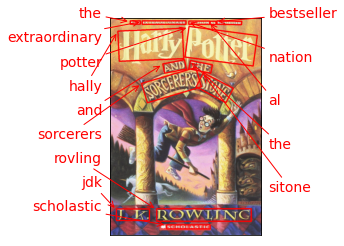


[Google OCR]
Texts:

"THE EXTRAORDINARY NATIONAL BESTSELLER
Harty Potter
AND
THE
SORGERERS STON
J. K. ROWIING
MSCHOLASTIC
"

"THE"

"EXTRAORDINARY"

"NATIONAL"

"BESTSELLER"

"Harty"

"Potter"

"AND"

"THE"

"SORGERERS"

"STON"

"J."

"K."

"ROWIING"

"MSCHOLASTIC"
bounds: (269,1098),(522,1099),(522,1115),(269,1114)

[Tesseract]
-: >

a

or

ea


ee

oe

my

oe 28)

EXTRAORDINARY

NATIONAL

eee pers

a




Se:

Fes)

Fy


eee

3

a}:

(f


i

x

hes te

Done


In [10]:
compare_ocr('book_1.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


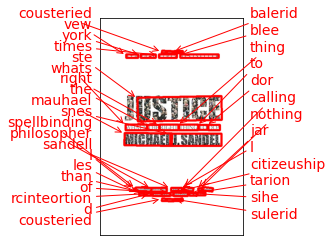


[Google OCR]
Texts:

"Copprighted Material
NE W YORK TIMES BESTSELLER
JUSTICE
WHAT'S THE RIGHT THING TO DO?
MICHAEL I.SANDEL
"A spellbinding philosopher ... Sandelj is calling .. for nothing
less than a reinvigoration of citizenship."-The Natton
Copprighted Material
"

"Copprighted"

"Material"

"NE"

"W"

"YORK"

"TIMES"

"BESTSELLER"

"JUSTICE"

"WHAT'S"

"THE"

"RIGHT"

"THING"

"TO"

"DO?"

"MICHAEL"

"I.SANDEL"

""A"

"spellbinding"

"philosopher"

"..."

"Sandelj"

"is"

"calling"

".."

"for"

"nothing"

"less"

"than"

"a"

"reinvigoration"

"of"

"citizenship."-The"

"Natton"

"Copprighted"

"Material"
bounds: (236,580),(261,580),(261,585),(236,585)

[Tesseract]
VY EF Wi

rPUORA

ri] ME Ss

288 Sa a ae OS A ee Ge

bees gee

WIiITALS

TR

RiCghil

THING

; ©

| ){ )?


6

Seana

:

"eos “ce ‘on

Done


In [11]:
compare_ocr('book_2.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


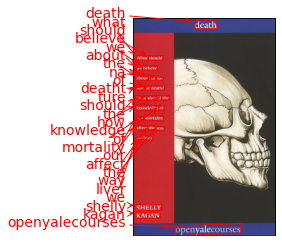


[Google OCR]
Texts:

"death
What should
we believe
about the na-
ture of death?
How should the
knowledge of
our mortality
affect the way
we live?
SHELLY
KAGAN
openyalecourses
"

"death"

"What"

"should"

"we"

"believe"

"about"

"the"

"na-"

"ture"

"of"

"death?"

"How"

"should"

"the"

"knowledge"

"of"

"our"

"mortality"

"affect"

"the"

"way"

"we"

"live?"

"SHELLY"

"KAGAN"

"openyalecourses"
bounds: (238,1168),(599,1166),(599,1219),(238,1221)

[Tesseract]
death

What

should

we

believe

abou

t the

tee

etice

of

deathe

wht

should

‘dele

knowledge

‘aia

OUT

mortality

af

tect the wa

y

We

Phteke

xe

SHELLY

AN er

@

eae!

eae

Gt

TSES

Done


In [12]:
compare_ocr('book_3.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


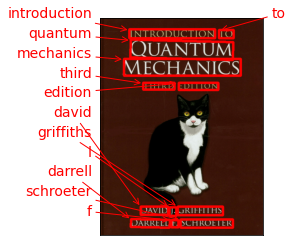


[Google OCR]
Texts:

"INTRODUCTION TO
QUANTUM
MECHANICS
THIRD EDITION
DAVID J. GRIFFITHS
DARRELL F. SCHROETER
"

"INTRODUCTION"

"TO"

"QUANTUM"

"MECHANICS"

"THIRD"

"EDITION"

"DAVID"

"J."

"GRIFFITHS"

"DARRELL"

"F."

"SCHROETER"
bounds: (228,566),(369,566),(369,584),(228,584)

[Tesseract]
IN TROPIDUCTLION

cE S

QUANTUM

MECHANICS

THEE I)

aDpIaerer

tt

LAVID

}.

Caisse

LYARRELL

r.

SCHROETER

Done


In [13]:
compare_ocr('book_4.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


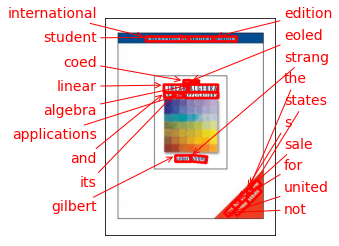


[Google OCR]
Texts:

"INTERNATIONAL STUDENT EDITION
foeth tiee
LINEAR ALGEBRA
AND ITS APPLICATIONS
Gilbert Strang
United States
Not for Sale in the
"

"INTERNATIONAL"

"STUDENT"

"EDITION"

"foeth"

"tiee"

"LINEAR"

"ALGEBRA"

"AND"

"ITS"

"APPLICATIONS"

"Gilbert"

"Strang"

"United"

"States"

"Not"

"for"

"Sale"

"in"

"the"
bounds: (389,453),(404,438),(412,447),(398,461)

[Tesseract]
iNIERNAITIUOUNAL

Weietaa.

te:

JIT iOnN

yy EEEEeEeEeEeEeEeEeEeEeEEeEeEeEeEEeEEeEeEeeeeeeeeeeeeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEeEO ee

1INEAR

ALGEBRA

ANU)

114

APPLICATIONS

Gilbert

Strang



mm allan

c

Done


In [14]:
compare_ocr('book_5.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


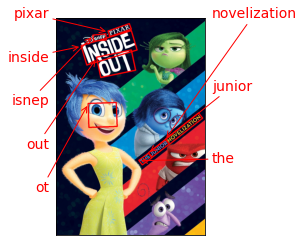


[Google OCR]
Texts:

"DisNEp · PIXAR
INSIDE
OUT
THE JUNIOR NOVELIZATION
"

"DisNEp"

"·"

"PIXAR"

"INSIDE"

"OUT"

"THE"

"JUNIOR"

"NOVELIZATION"
bounds: (594,658),(762,527),(776,545),(608,676)

[Tesseract]
2

Done


In [15]:
compare_ocr('book_6.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


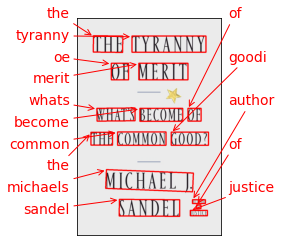


[Google OCR]
Texts:

"THE TYRANNY
OF MERIT
WHAT'S BECOME OF
THE COMMON GOOD?
MICHAEL J.
SANDEL
AUTHOR
OF
JUSTICE
"

"THE"

"TYRANNY"

"OF"

"MERIT"

"WHAT'S"

"BECOME"

"OF"

"THE"

"COMMON"

"GOOD?"

"MICHAEL"

"J."

"SANDEL"

"AUTHOR"

"OF"

"JUSTICE"
bounds: (631,1074),(719,1075),(719,1105),(631,1104)

[Tesseract]
THE

TYRANNY

()

MERIT

ya

WHATS

BECOME

() |:

THE

(COMMON

GOO)?

MICHAEL

)

VANDEL che

Done


In [16]:
compare_ocr('book_7.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


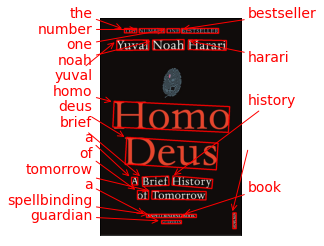


[Google OCR]
Texts:

"THE NUMBER ONE BESTSELLER
Yuval Noah Harari
Homo
Deus
A Brief History
of Tomorrow
'A SPELLBINDING BOOK'
GUARDIAN
VINTAGE
"

"THE"

"NUMBER"

"ONE"

"BESTSELLER"

"Yuval"

"Noah"

"Harari"

"Homo"

"Deus"

"A"

"Brief"

"History"

"of"

"Tomorrow"

"'A"

"SPELLBINDING"

"BOOK'"

"GUARDIAN"

"VINTAGE"
bounds: (763,1104),(764,1187),(749,1187),(748,1104)

[Tesseract]
THER

NUMBER

Oa

K BESTSELLER

Yuval

Noah

Harari

c

Homo

| DYaurs

A

Briet

ristory

ot

Tomorrow

we

SPELLBINDING

BOOK:

GUARDIAN


Done


In [17]:
compare_ocr('book_8.jpg')

## 4. 추가 테스트


### 맥주 찾기 OCR
* 의도: 주어진 맥주 이미지를 이용하여, 맥주의 이름을 알려주는 서비스

In [18]:
img_dir = os.getenv('HOME')+'/aiffel/ocr_python/beers'
file_list = os.listdir(img_dir)
file_list

['beer_2.png',
 'beer_6.png',
 'beer_5.png',
 'beer_8.png',
 'beer_9.png',
 'beer_3.png',
 'beer_7.png',
 'beer_4.png',
 'beer_10.png',
 'beer_1.png']

## Google OCR API

In [19]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    print(f'[{file}]')
    detect_text(os.path.join(img_dir, file))
    print()

[beer_2.png]
Texts:

"IMPORTED
FROM
ENGLAND
re one and On
The
STLE
NEW
BRO
ALE
"

"IMPORTED"

"FROM"

"ENGLAND"

"re"

"one"

"and"

"On"

"The"

"STLE"

"NEW"

"BRO"

"ALE"
bounds: (178,759),(222,676),(262,697),(218,780)

[beer_6.png]
Texts:

"@123RF
BECKS
O123 RF
REGISTEREDRADEMARK
BECKS
BREMEN 181
GERMANY
a23RF
RAUEREI
BECK & C.
BREMEN
1873
ESTP 18
"

"@123RF"

"BECKS"

"O123"

"RF"

"REGISTEREDRADEMARK"

"BECKS"

"BREMEN"

"181"

"GERMANY"

"a23RF"

"RAUEREI"

"BECK"

"&"

"C."

"BREMEN"

"1873"

"ESTP"

"18"
bounds: (365,1001),(374,986),(396,998),(386,1014)

[beer_5.png]
Texts:

"S MUEL
DAMS
ON LA
SAMUEL
ADAMS
BOSTON LAGER
"

"S"

"MUEL"

"DAMS"

"ON"

"LA"

"SAMUEL"

"ADAMS"

"BOSTON"

"LAGER"
bounds: (228,318),(257,317),(257,331),(228,332)

[beer_8.png]
Texts:

"JAGER BER
Heineken
PREMIUM
RI NA
33d 43imm LL
ALITYO
Heineken
"

"JAGER"

"BER"

"Heineken"

"PREMIUM"

"RI"

"NA"

"33d"

"43imm"

"LL"

"ALITYO"

"Heineken"
bounds: (289,191),(290,100),(308,100),(307,191)

[beer_9.png]

## keras-ocr

In [20]:
images = [keras_ocr.tools.read(os.path.join(img_dir, file)) for file in file_list]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, file)]) for file in file_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


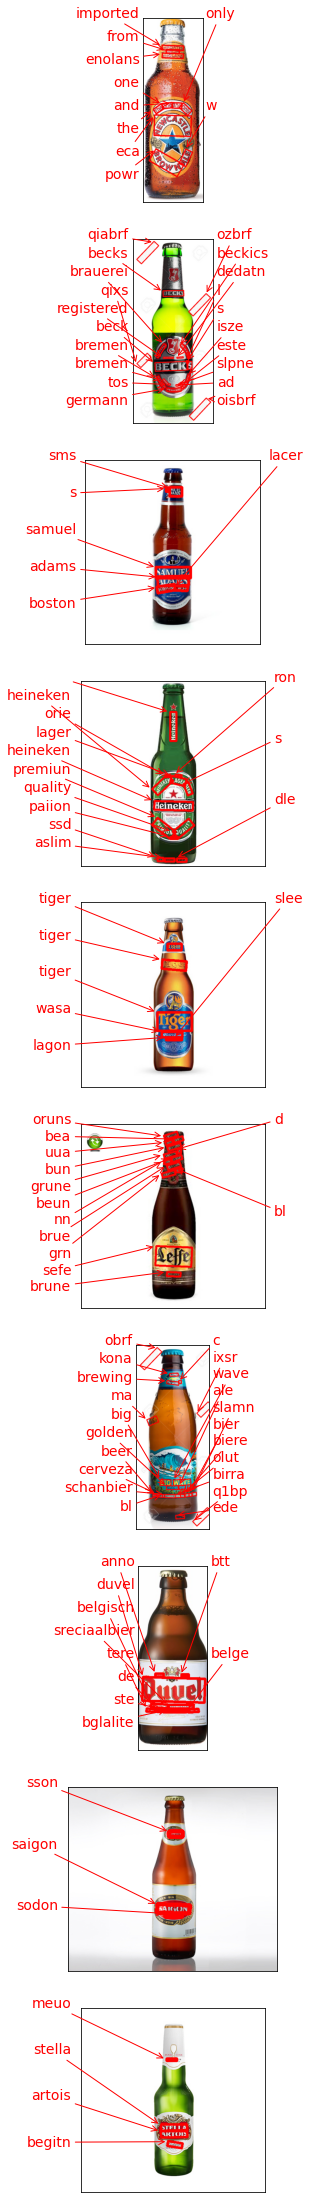

In [21]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract

In [22]:
save_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_cropped'

for file in file_list:
    print(f'[{file}]')
    try:
        recognize_images(os.path.join(img_dir, file), save_dir)
    except:
        print(f'Cannot recognize characters from {file}')

[beer_2.png]

Done
[beer_6.png]
:

Done
[beer_5.png]
4

Done
[beer_8.png]
—

—_—_—_

5

as

&

3?

<=

.

Done
[beer_9.png]

Done
[beer_3.png]
Cannot recognize characters from beer_3.png
[beer_7.png]
i

e

.

,

4



j

Rl

Audie

vale

ren

Done
[beer_4.png]
‘a

Done
[beer_10.png]
‘

Done
[beer_1.png]


ES

Shane:

Wed

TOIS

Done


[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


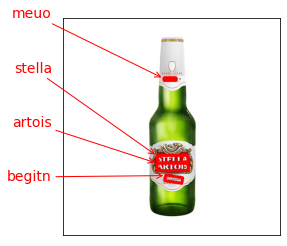


[Google OCR]
Texts:

"ANNO136
PREMIUM
LAGER BEES
STELLA
ARTOIS
Belgium
"

"ANNO136"

"PREMIUM"

"LAGER"

"BEES"

"STELLA"

"ARTOIS"

"Belgium"
bounds: (233,361),(273,362),(272,381),(232,380)

[Tesseract]


ES

Shane:

Wed

TOIS

Done


In [23]:
compare_ocr('beer_1.png')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


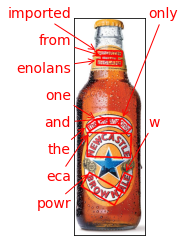


[Google OCR]
Texts:

"IMPORTED
FROM
ENGLAND
re one and On
The
STLE
NEW
BRO
ALE
"

"IMPORTED"

"FROM"

"ENGLAND"

"re"

"one"

"and"

"On"

"The"

"STLE"

"NEW"

"BRO"

"ALE"
bounds: (178,759),(222,676),(262,697),(218,780)

[Tesseract]

Done


In [24]:
compare_ocr('beer_2.png')

## 5. 회고

* Google OCR API: 텍스트와 같은 단순한 문자들을 비롯하여, 인물 이미지를 이용하여 만든 문자들도 잘 인식하였다. 또한, 회전된 문자들에 대해서도 잘 인식했다. 따라서, 3가지의 ocr 모델 중에서 문자 인식률이 가장 높다고 판단된다. 
  
  
  
* keras-ocr: 텍스트와 같은 단순한 문자들은 잘 인식하지만, 회전된 문자나 그림과 같이 디자인 된 문자들에 대해서는 인식률이 낮았다.
  
  
  
* Tesseract: 3가지 모델 중 가장 성능이 좋지 않았다고 얘기할 수 있다. 대부분의 이미지들에 대해서 인식률이 떨어졌으며, 단순한 텍스트 문자가 아닌 이상, 활용하기에는 어려움이 따른다고 판단된다.
--- 

* 가장 활용도가 높은 OCR 모델은 Google OCR API라고 생각된다. 여러 종류의 문자들에 대해서 인식률이 굉장히 높았으며, 다양한 문자들을 정상적으로 인식할 수 있었다. 반면, Tesseract는 단순한 텍스트 형식의 문자를 제외한 나머지 문자들에 대해서는 인식률이 굉장히 낮았으며, OCR 모델로서 정상적인 사용이 가능한지에 대한 의문이 들었다. Tesseract는 인쇄된 책의 내용을 읽고 해당 문장을 번역해주는 방식의 기술로 사용할 수 있겠지만, 다른 응용 기술에는 사용이 힘들 것이라고 생각된다. 반면 Google OCR API의 경우, 다양한 형태의 문자들을 인식하고, 인식률 또한 높기 때문에, 다양한 응용 기술에서 사용할 수 있을 것이라고 생각된다. 앞으로의 OCR 기술에서는 Google OCR API가 우세하지 않을까 예측한다. 